# Selecting a Good Check Standard Measurement
## 1. Input A Raw Measurement File From MEASLP
## 2. Calrep The Raw File to Find Uncertainties
## 3. Find a Results File And Compare
## 4. Compare the Difference With The Calrep Uncertainties 
## 5. Compare the Standard Error

In [1]:
import wx
from pyMeasure import *

Importing Code.Utils.Names
Importing Code.DataHandlers.NISTModels
The module smithplot was not found,please put it on the python path
Importing Code.DataHandlers.GeneralModels
Importing Code.DataHandlers.TouchstoneModels
The module smithplot was not found,please put it on the python path
Importing Code.DataHandlers.XMLModels
Importing Code.DataHandlers.RadiCALModels
Importing Code.DataHandlers.ZipModels
Importing Code.DataHandlers.Translations
Importing Code.DataHandlers.StatistiCALModels
Importing Code.DataHandlers.MUFModels
Importing Code.Analysis.SParameter
Importing Code.InstrumentControl.Instruments
Importing Code.InstrumentControl.Experiments


<IPython.core.display.Javascript object>


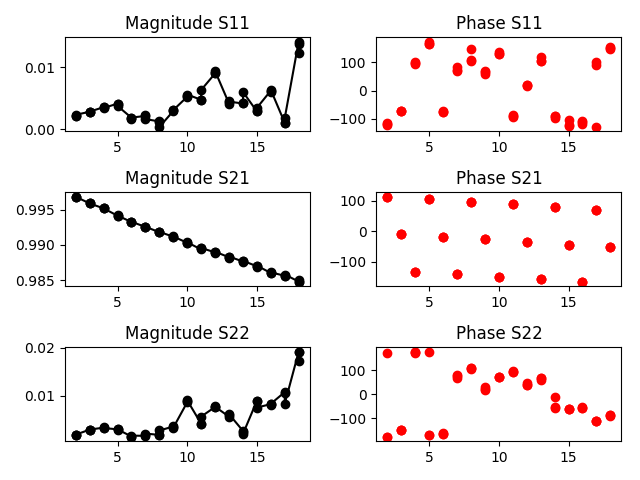

In [19]:
%matplotlib notebook
file_path=r'C:\Share\Ck_Std_raw_ascii\C07205.D44_072600'
raw_measurement_model=sparameter_power_type(file_path)
raw_measurement=globals()[raw_measurement_model](file_path)
raw_measurement.show();

average_columns is ['magS11', 'argS11', 'magS21', 'argS21', 'magS22', 'argS22']


<IPython.core.display.Javascript object>


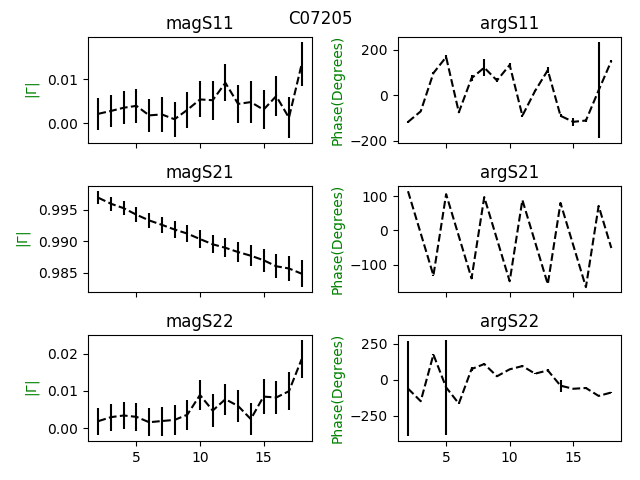

Length of x is 17, Length of y is 17, Length of error is 17
Length of x is 17, Length of y is 17, Length of error is 17
Length of x is 17, Length of y is 17, Length of error is 17


In [20]:
calrep_measurement=calrep(raw_measurement)
plot_calrep(calrep_measurement);

In [22]:
calrep_measurement.metadata["Measurement_Type"]

'2-port'

In [26]:
results_file=ResultFileModel(os.path.join(r'C:\Share\resfiles',calrep_measurement.metadata["Device_Id"]))

In [65]:

def plot_calrep_results_comparison(calrep_model, results_model, **options):
    """Plots a calrep file and a results file on the same axis. Input is a calrep table from the sparameter
    function calrep and a
    results file, with options. """
    defaults = {"display_legend": True,
                "save_plot": False,
                "directory": None,
                "specific_descriptor": "comparison_Plot",
                "general_descriptor": "Plot",
                "file_name": None,
                "labels": None,
                "error_suffix": 'g',
                "calrep_format": 'k-x',
                "results_format": 'r-x'}
    comparison_plot_options = {}
    for key, value in defaults.iteritems():
        comparison_plot_options[key] = value
    for key, value in options.iteritems():
        comparison_plot_options[key] = value
    # figure out the number of plots based on the measurement type
    measurement_type = calrep_model.metadata["Measurement_Type"]
    if re.search('1|one', measurement_type, re.IGNORECASE):
        number_plots = 2
        column_names = ['magS11', 'argS11']
    elif re.search('2|two', measurement_type, re.IGNORECASE):
        if re.search('NR', measurement_type, re.IGNORECASE):
            number_plots = 8
            column_names = ['magS11', 'argS11', 'magS12', 'argS12', 'magS21', 'argS21', 'magS22', 'argS22']
        else:
            number_plots = 6
            column_names = ['magS11', 'argS11', 'magS21', 'argS21', 'magS22', 'argS22']
    else:
        number_plots = 3
        column_names = ['magS11', 'argS11', 'Efficiency']
    # create the error column names
    error_columns = []
    for column in column_names[:]:
        error_column = column.replace("mag", "uM" + comparison_plot_options["error_suffix"])
        error_column = error_column.replace("arg", "uA" + comparison_plot_options["error_suffix"])
        error_column = error_column.replace("Efficiency", "uE" + comparison_plot_options["error_suffix"])
        error_columns.append(error_column)

    # We want plots that have frequency as the x-axis and y that has an error 
    calrep_x = calrep_model["Frequency"]
    results_x = results_model["Frequency"]
    number_rows = int(round(float(number_plots) / 2))
    fig, compare_axes = plt.subplots(nrows=number_rows, ncols=2, sharex='col', figsize=(8, 6), dpi=80)
    # each axis has an error column     
    for plot_index, ax in enumerate(compare_axes.flat[:]):
        calrep_y = np.array(calrep_model[column_names[plot_index]])
        results_y = np.array(results_model[column_names[plot_index]])
        error = np.array(calrep_model[error_columns[plot_index]])
        ax.plot(calrep_x, calrep_y, comparison_plot_options['calrep_format'],
                label='Calrep of {0}'.format(calrep_model.metadata["Device_Id"]))
        ax.fill_between(calrep_x, calrep_y - error, calrep_y + error, edgecolor=(0, .0, .0, .25),
                        facecolor=(.25, .25, .25, .1),
                        linewidth=1)
        ax.plot(results_x, results_y, comparison_plot_options['results_format'], label="Reference File")
        if comparison_plot_options["display_legend"]:
            ax.legend()

    # Dealing with the save option
    if comparison_plot_options["file_name"] is None:
        file_name = auto_name(specific_descriptor=comparison_plot_options["specific_descriptor"],
                              general_descriptor=comparison_plot_options["general_descriptor"],
                              directory=comparison_plot_options["directory"]
                              , extension='png', padding=3)
    else:
        file_name = comparison_plot_options["file_name"]
    if comparison_plot_options["save_plot"]:
        # print file_name
        plt.savefig(os.path.join(comparison_plot_options["directory"], file_name))
    else:
        plt.show()
    return fig

<IPython.core.display.Javascript object>


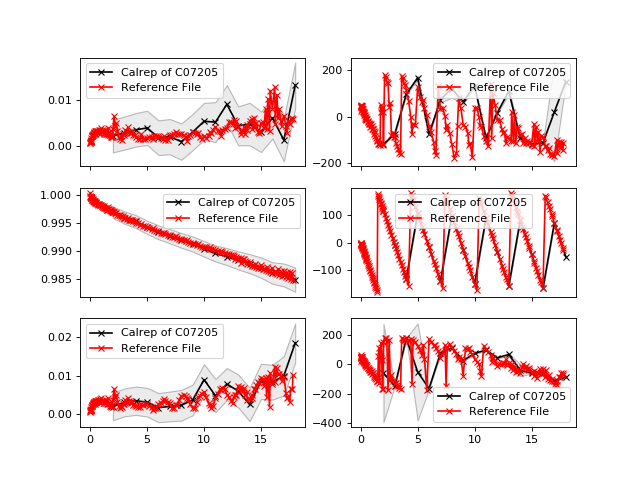

In [66]:
plot_calrep_results_comparison(calrep_measurement,results_file);

In [52]:
def frequency_model_difference(model_1,model_2,**options):
    """Takes the difference of two models that both have frequency and a similar set of columns. Returns an object that is 
    a list of [[frequency,column_1,..column_n],...] where columns are the same in the models. If  a particular subset of 
    columns is desired use columns=["Frequency","magS11] models can be any subclass of AsciiDataTable, SNP, or 
    pandas.DataFrame, if a column is a non-numeric type it drops it. The frequency list should be unique 
    (no multiple frequencies) for at least one model"""
    # Set up defaults and pass options
    defaults={"columns":"all","interpolate":False,"average":True}
    difference_options={}
    for key,value in defaults.iteritems():
        difference_options[key]=value
    for key,value in options.iteritems():
        difference_options[key]=value
        
    # first check type, if it is a panadas data frame a little conversion is needed, else is for all other models
    if type(model_1) in [pandas.DataFrame]:
        model_1=DataFrame_to_AsciiDataTable(model_1)
    if type(model_2) in [pandas.DataFrame]:
        model_2=DataFrame_to_AsciiDataTable(model_2)
    # now start with a set of frequencies (unique values from both)
    frequency_set_1=set(model_1["Frequency"])
    frequency_set_2=set(model_2["Frequency"])
    model_2_frequency_selector=model_2.column_names.index('Frequency')
    column_names_set_1=set(model_1.column_names)
    column_names_set_2=set(model_2.column_names)
    

    # All points must be in the intersection to be used
    frequency_intersection=list(frequency_set_1.intersection(frequency_set_2))
    column_names_intersection=list(column_names_set_1.intersection(column_names_set_2))
    
    if not frequency_intersection:
        print("The models do not have any frequency points in common")
        return None
    new_column_names=["Frequency"]
    difference_data=[]
    for row_index,frequency in enumerate(model_1["Frequency"]):
        new_row=[frequency]
        if frequency in frequency_intersection:
            model_2_frequency_row=filter(lambda x: x[model_2_frequency_selector]==frequency,model_2.data)[0]
            #print("{0} is {1}".format("model_2_frequency_row",model_2_frequency_row))
            for column_index,column in enumerate(model_1.column_names):
                if column in column_names_intersection and column not in ["Frequency"]:
                    model_2_column_selector=model_2.column_names.index(column)
                    if re.search('int|float',
                                 model_1.options["column_types"][column_index],
                                 re.IGNORECASE) and re.search('int|float',
                                                              model_2.options["column_types"][model_2_column_selector],
                                                              re.IGNORECASE):
                        
                        new_row.append(model_1.data[row_index][column_index]-model_2_frequency_row[model_2_column_selector])
                        new_column_names.append(column)
                        #Print("New Column Names are {0}".format(new_column_names))
                    elif difference_options["columns"] in ["all"]:
                        new_row.append(model_1.data[row_index][column_index])
                        new_column_names.append(column)
            difference_data.append(new_row)
    difference_options["column_names"]=new_column_names
    #print("New Column Names are {0}".format(new_column_names))
    difference_options["data"]=difference_data      
    result=AsciiDataTable(None,**difference_options)
    return result

In [63]:

def plot_calrep_results_difference_comparison(calrep_model, results_model, **options):
    """Plots a calrep file and a results file on the same axis. Input is a calrep table from the sparameter
    function calrep and a
    results file, with options. """
    defaults = {"display_legend": False,
                "save_plot": False,
                "directory": None,
                "specific_descriptor": "comparison_Plot",
                "general_descriptor": "Plot",
                "file_name": None,
                "labels": None,
                "error_suffix": 'g',
                "calrep_format": 'r-x',
                "results_format": 'r-x',
                "debug":False,
                "title":'Calrep diiference of {0}'.format(calrep_model.metadata["Device_Id"])}
    comparison_plot_options = {}
    for key, value in defaults.iteritems():
        comparison_plot_options[key] = value
    for key, value in options.iteritems():
        comparison_plot_options[key] = value
    # figure out the number of plots based on the measurement type
    measurement_type = calrep_model.metadata["Measurement_Type"]
    if re.search('1|one', measurement_type, re.IGNORECASE):
        number_plots = 2
        column_names = ['magS11', 'argS11']
    elif re.search('2|two', measurement_type, re.IGNORECASE):
        if re.search('NR', measurement_type, re.IGNORECASE):
            number_plots = 8
            column_names = ['magS11', 'argS11', 'magS12', 'argS12', 'magS21', 'argS21', 'magS22', 'argS22']
        else:
            number_plots = 6
            column_names = ['magS11', 'argS11', 'magS21', 'argS21', 'magS22', 'argS22']
    else:
        number_plots = 3
        column_names = ['magS11', 'argS11', 'Efficiency']
    # create the error column names
    error_columns = []
    for column in column_names[:]:
        error_column = column.replace("mag", "uM" + comparison_plot_options["error_suffix"])
        error_column = error_column.replace("arg", "uA" + comparison_plot_options["error_suffix"])
        error_column = error_column.replace("Efficiency", "uE" + comparison_plot_options["error_suffix"])
        error_columns.append(error_column)
    difference_model=frequency_model_difference(calrep_model,results_model)
    if comparison_plot_options["debug"]:
        print("{0} is {1}".format("difference_model.column_names",difference_model.column_names))
    # We want plots that have frequency as the x-axis and y that has an error 
    difference_x=difference_model["Frequency"]
    calrep_x=calrep_model["Frequency"]
    number_rows = int(round(float(number_plots) / 2))
    fig, compare_axes = plt.subplots(nrows=number_rows, ncols=2, sharex='col', figsize=(8, 6), dpi=80)
    # each axis has an error column     
    for plot_index, ax in enumerate(compare_axes.flat[:]):

        difference_y=np.array(difference_model[column_names[plot_index]])
        error = np.array(calrep_model[error_columns[plot_index]])
        ax.plot(difference_x, difference_y, comparison_plot_options['calrep_format'],
                label='Calrep diiference of {0}'.format(calrep_model.metadata["Device_Id"]))
        ax.fill_between(calrep_x, - error,  error, edgecolor=(0, .0, .0, .25),
                        facecolor=(.25, .25, .25, .1),
                        linewidth=1)
        if comparison_plot_options["display_legend"]:
            ax.legend()
                                                          
    if comparison_plot_options["title"]:
            fig.suptitle(comparison_plot_options["title"])

    # Dealing with the save option
    if comparison_plot_options["file_name"] is None:
        file_name = auto_name(specific_descriptor=comparison_plot_options["specific_descriptor"],
                              general_descriptor=comparison_plot_options["general_descriptor"],
                              directory=comparison_plot_options["directory"]
                              , extension='png', padding=3)
    else:
        file_name = comparison_plot_options["file_name"]
    if comparison_plot_options["save_plot"]:
        # print file_name
        plt.savefig(os.path.join(comparison_plot_options["directory"], file_name))
    else:
        plt.show()
    return fig

<IPython.core.display.Javascript object>


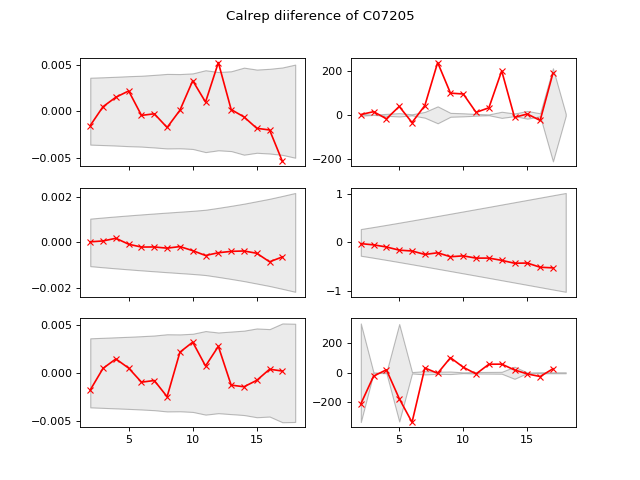

In [64]:
plot_calrep_results_difference_comparison(calrep_measurement,results_file);

In [67]:
from pyMeasure.Code.Analysis.Uncertainty import *

<IPython.core.display.Javascript object>


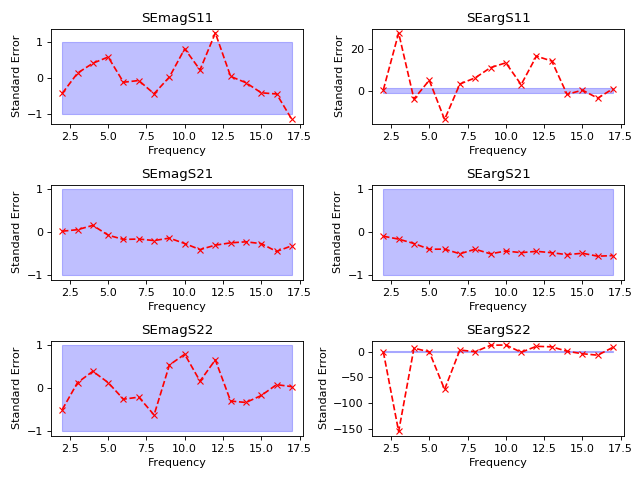

{'SEargS11': False, 'SEmagS11': False, 'Frequency': True, 'SEmagS22': True, 'SEmagS21': True, 'SEargS21': True, 'SEargS22': False}


In [69]:
standard_error=standard_error_data_table(calrep_measurement,results_file)
standard_error.show();
print standard_error.get_conformation_dictionary()